In [5]:
# import numpy as np
# import matplotlib.pyplot as plt

# def read_binary_file2d(filename):
#     # Read the binary file
#     with open(filename, 'rb') as file:
#         depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
#         rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
#         cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
        
#         data = np.fromfile(file, dtype=np.float32)
#         data = data.reshape((depth, rows, cols))

#     # Extract subbands
#     LL = data[:, :rows//2, :cols//2]
#     LH = data[:, :rows//2, cols//2:]
#     HL = data[:, rows//2:, :cols//2]
#     HH = data[:, rows//2:, cols//2:]

#     # Create a dictionary to store the subbands
#     subbands = {
#         'LL': LL,
#         'LH': LH,
#         'HL': HL,
#         'HH': HH
#     }

#     return subbands

# def normalize(data):
#     data = np.abs(data)
#     data = data / np.max(data)
#     return data

# def display_images(data, title, transform_type):
#     fig, axes = plt.subplots(1, 4, figsize=(20, 5))
#     fig.suptitle(title, fontsize=16)
    
#     keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
#     for i, key in enumerate(keys):
#         if key not in data:
#             print(f"Key '{key}' not found in data")
#             continue
#         # Get the first slice along the depth dimension
#         value = data[key][0]  # Display the first "depth" slice
#         value = normalize(value)  # Normalize the data
#         axes[i].imshow(value, cmap='gray')
#         axes[i].set_title(f'{transform_type} {key}')
#         axes[i].axis('off')
    
#     plt.show()

# # Read the binary file for 2D wavelet transform
# filename = '../Serial/outputs/3out.bin'
# data_2d = read_binary_file2d(filename)

# # Debug statement to print the keys of the data structure
# print("Keys in data_2d:", data_2d.keys())

# # Display the images for 2D wavelet transform
# display_images(data_2d, '2D Wavelet Transform', '2D')

Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232
Low-pass filter coefficients for haar: [0.7071067811865476, 0.7071067811865476]
High-pass filter coefficients for haar: [-0.7071067811865476, 0.7071067811865476]


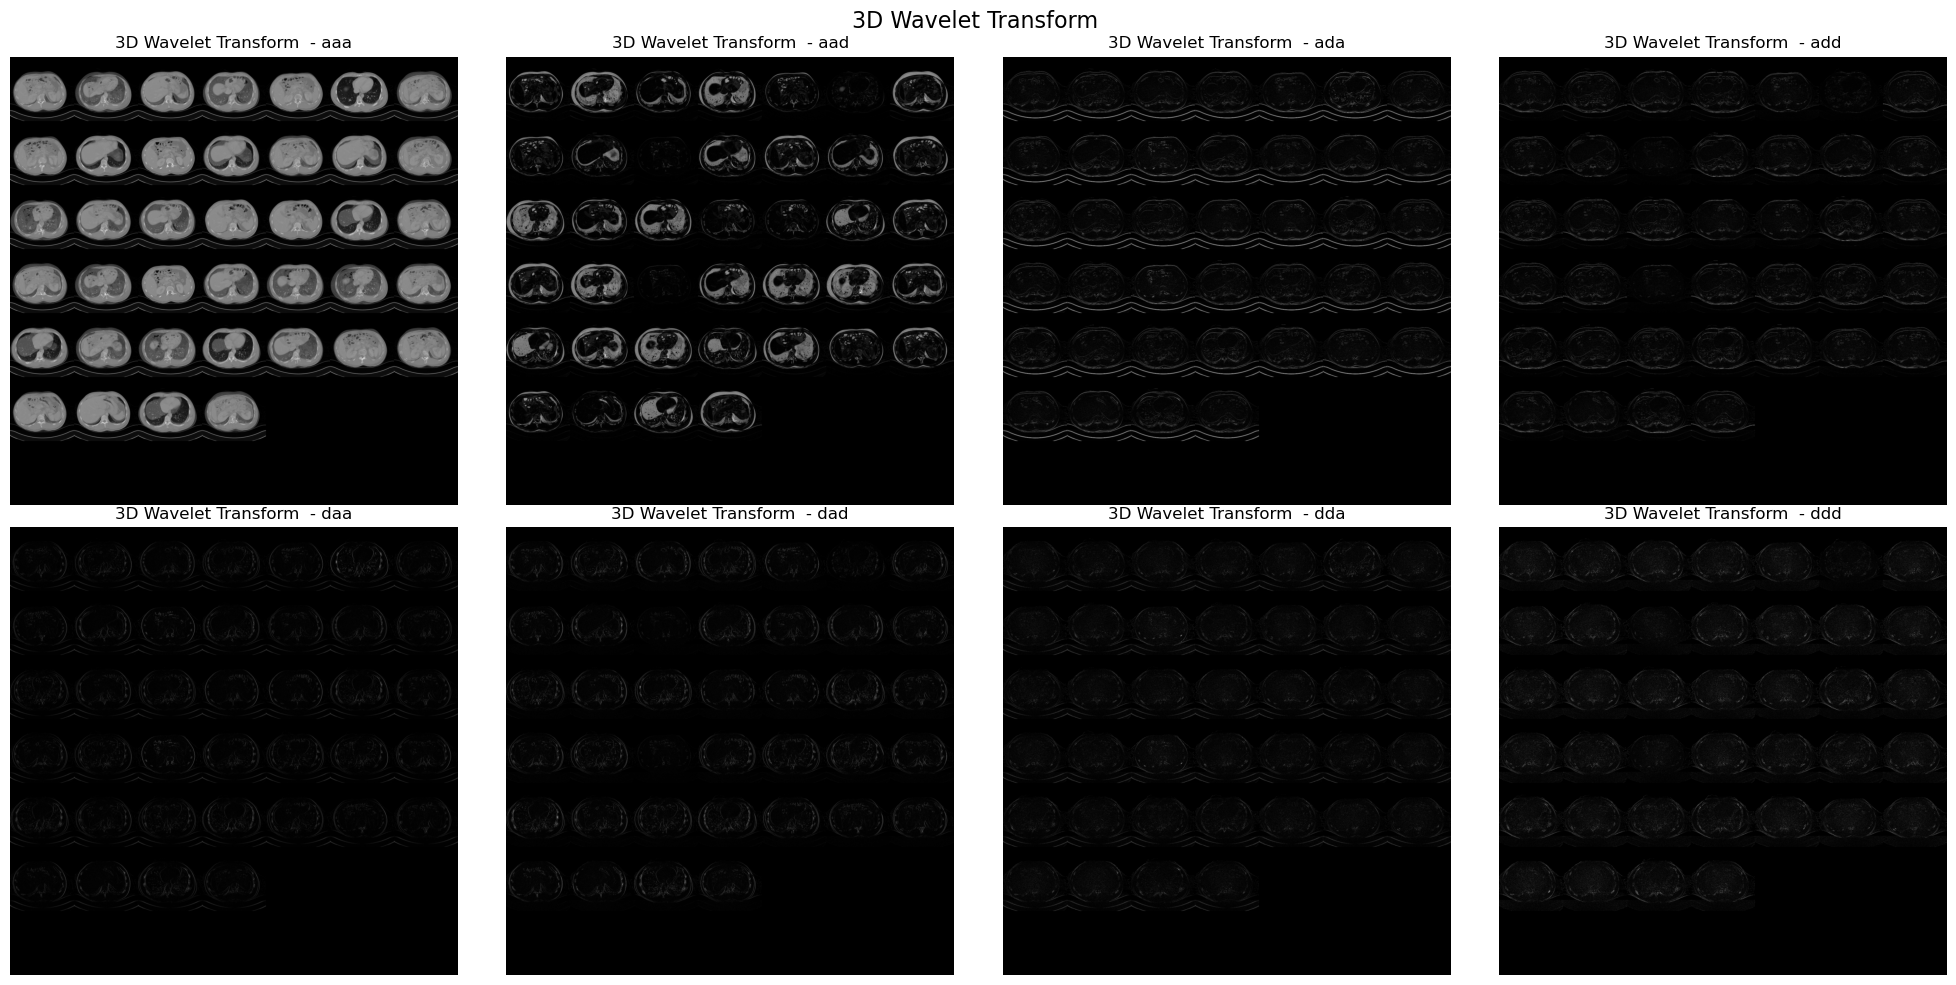

<Figure size 640x480 with 0 Axes>

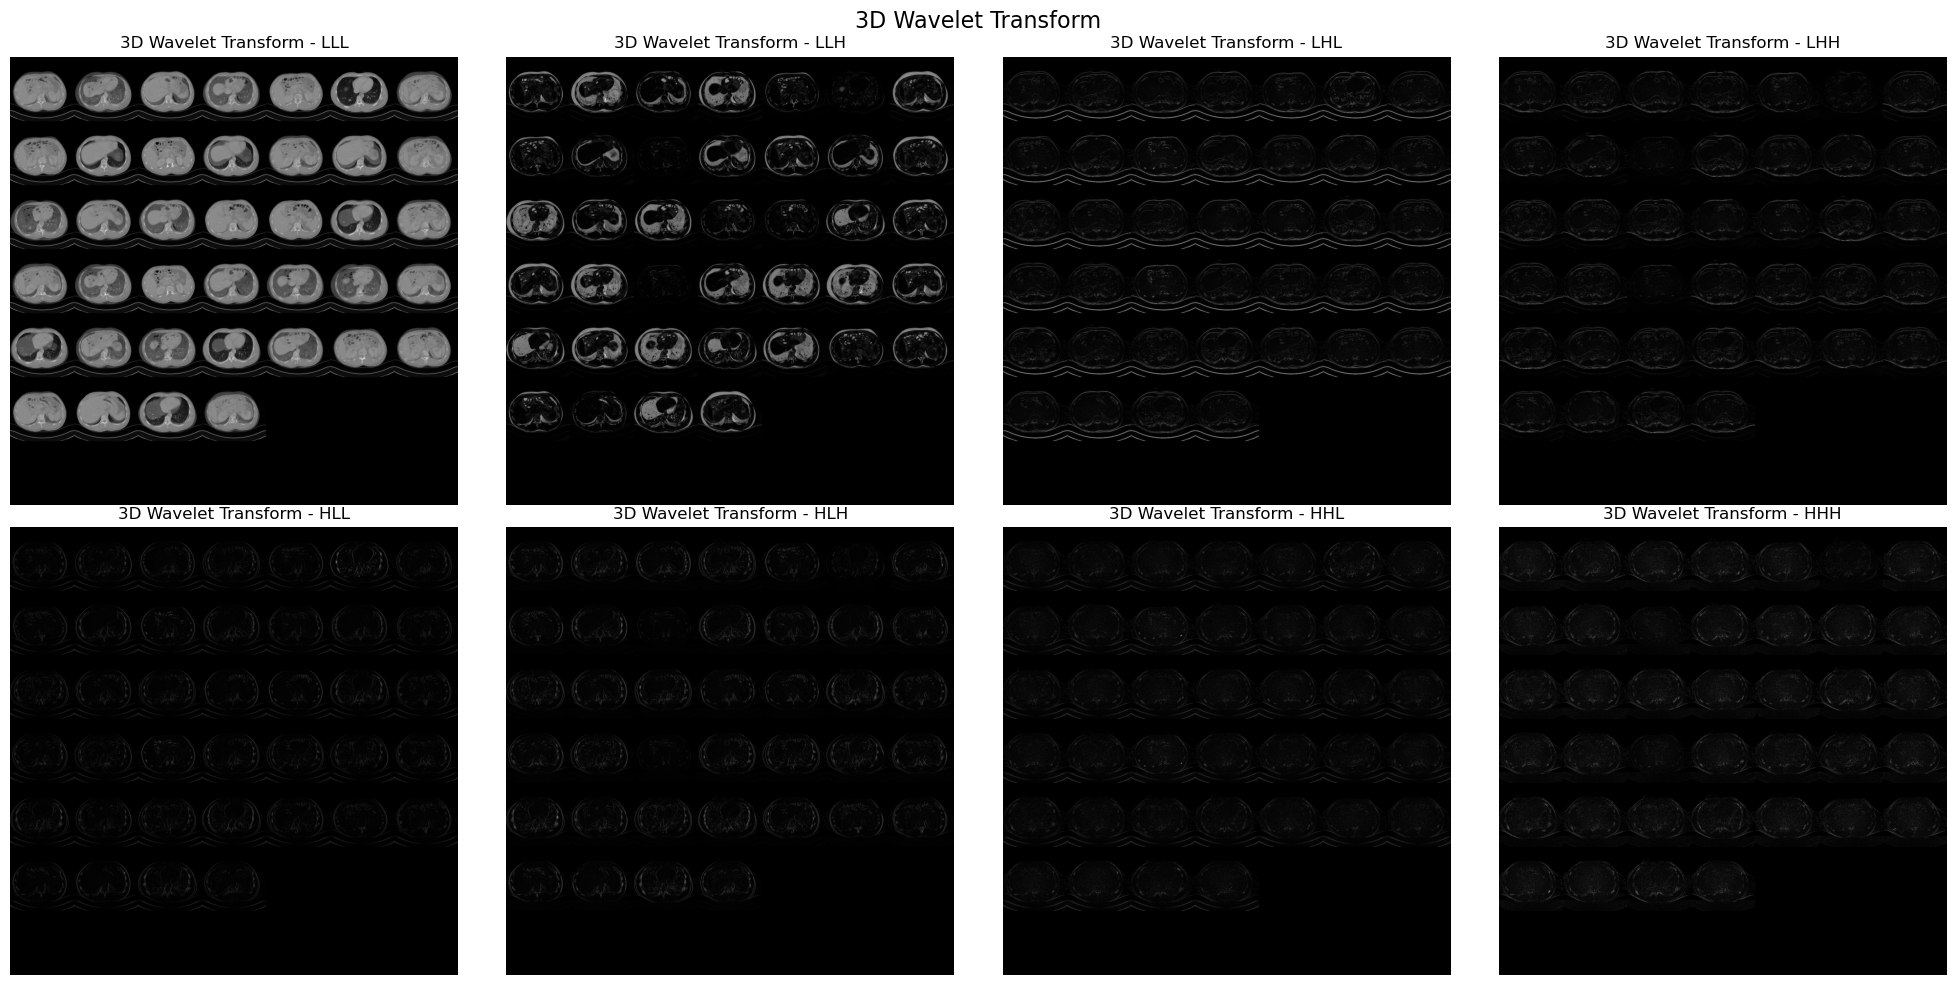

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import math


def perform_3d_wavelet_transform_pywt(data, wavelet, mode):
    coeffs = pywt.dwtn(data, wavelet=wavelet, mode=mode, axes=(2, 1, 0))
    return coeffs

def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

def read_binary_file(filename, shape_filename):
    # Read the shape information
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    # Read the binary file
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
    return data

def read_wavelet3d_result(filename):
    subbands = {}
    with open(filename, 'rb') as file:
        for key in ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key] = data
    return subbands

def normalize(data):
    data = np.abs(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    return data

def normalize(data):
    data = np.abs(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    return data

def map_slices_to_square(volume):
    """
    Arranges the 3D volume of DICOM slices into a single 2D image by tiling them
    in a roughly square grid.
    
    Parameters:
        volume (numpy.ndarray): A 3D array where each slice is a 2D image.
        
    Returns:
        numpy.ndarray: A 2D array containing the tiled image.
    """
    # Get number of slices and the shape of each slice
    num_slices, height, width = volume.shape
    
    # Calculate the grid size needed for a square layout
    grid_size = math.ceil(math.sqrt(num_slices))
    
    # Initialize a large empty canvas for the tiled image
    tiled_image = np.zeros((grid_size * height, grid_size * width), dtype=volume.dtype)
    
    # Place each slice in the grid
    for i in range(num_slices):
        row = i // grid_size
        col = i % grid_size
        tiled_image[row * height: (row + 1) * height, col * width: (col + 1) * width] = volume[i]
    
    return tiled_image

def display_images(data, title, keys):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    for i, key in enumerate(keys):
        if key not in data:
            print(f"Key '{key}' not found in data")
            continue
        # Tile the entire volume into a single 2D image
        value = map_slices_to_square(data[key])
        value = normalize(value)
        ax = axes[i // 4, i % 4]
        ax.imshow(value, cmap='gray')
        ax.set_title(f'{title} - {key}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()

# Read the original input data
original_filename = '../../Final/data/3/3.bin'
shape_filename = '../../Final/data/3/3_shape.txt'
original_data = read_binary_file(original_filename, shape_filename)

# Allow user to specify the wavelet filter
wavelet_name = 'haar'  # Change this to any wavelet filter you want to use
coeffs_pywt = perform_3d_wavelet_transform_pywt(original_data, wavelet=wavelet_name, mode='periodization')

# Print filter coefficients
wavelet = pywt.Wavelet(wavelet_name)
print(f"Low-pass filter coefficients for {wavelet_name}: {wavelet.dec_lo}")
print(f"High-pass filter coefficients for {wavelet_name}: {wavelet.dec_hi}")

# Read the results from the C++ implementation
cpp_filename = '../../Final/serial/outputs/3out.bin'
data_cpp = read_wavelet3d_result(cpp_filename)

# Display the images for 3D wavelet transform using PyWavelets
display_images(coeffs_pywt, '3D Wavelet Transform ', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'])

# Display the images for 3D wavelet transform from C++ implementation
display_images(data_cpp, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])


In [7]:
for key, value in coeffs_pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband aaa: (39, 256, 256)
Resolution of subband aad: (39, 256, 256)
Resolution of subband ada: (39, 256, 256)
Resolution of subband add: (39, 256, 256)
Resolution of subband daa: (39, 256, 256)
Resolution of subband dad: (39, 256, 256)
Resolution of subband dda: (39, 256, 256)
Resolution of subband ddd: (39, 256, 256)


In [8]:
for key, value in data_cpp.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband LLL: (39, 256, 256)
Resolution of subband LLH: (39, 256, 256)
Resolution of subband LHL: (39, 256, 256)
Resolution of subband LHH: (39, 256, 256)
Resolution of subband HLL: (39, 256, 256)
Resolution of subband HLH: (39, 256, 256)
Resolution of subband HHL: (39, 256, 256)
Resolution of subband HHH: (39, 256, 256)
